Make a copy of this notebook and rename using your USERID in the following format, 2017CSZ8058

Give read access to keshavkolluru@gmail.com, vishalsaley114@gmail.com and kartikeya.badola@gmail.com


In [1]:
## DONT CHANGE THIS CELL
!wget http://www.cse.iitd.ac.in/~mausam/courses/col772/autumn2021/A3/data.zip

--2021-10-25 18:11:10--  http://www.cse.iitd.ac.in/~mausam/courses/col772/autumn2021/A3/data.zip
Resolving www.cse.iitd.ac.in (www.cse.iitd.ac.in)... 103.27.9.152
Connecting to www.cse.iitd.ac.in (www.cse.iitd.ac.in)|103.27.9.152|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cse.iitd.ac.in/~mausam/courses/col772/autumn2021/A3/data.zip [following]
--2021-10-25 18:11:11--  https://www.cse.iitd.ac.in/~mausam/courses/col772/autumn2021/A3/data.zip
Connecting to www.cse.iitd.ac.in (www.cse.iitd.ac.in)|103.27.9.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 217313 (212K) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 212.22K   188KB/s    in 1.1s    

2021-10-25 18:11:12 (188 KB/s) - ‘data.zip’ saved [217313/217313]



In [2]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/train/
  inflating: data/train/train.gold.txt  
  inflating: data/train/train.data.txt  
   creating: data/validation/
  inflating: data/validation/validation.data.txt  
  inflating: data/validation/validation.gold.txt  


In [3]:
## Import relevant packages
import os
import re
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# from torchtext.legacy.data import Field, TabularDataset, BucketIterator

In [4]:
## Limiting randomness
torch.manual_seed(0)
np.random.seed(0)

## Creating .CSV Dataset

In [5]:
def csv_creator(path_data='/content/drive/MyDrive/COL772_A3_B/data/train/train.data.txt', path_gold='/content/drive/MyDrive/COL772_A3_B/data/train/train.gold.txt', path_dir='content/', is_label=False, kind='train'):
    ## Reading Data File
    train_list = []
    count = 1
    with open(path_data, 'r') as f:
        for line in f:
            line = line.rstrip('\n')
            line = line.split('\t')
            token = line[0]
            entity = line[1]
            pos = line[2].split('-')
            pos1 = pos[0]
            pos2 = pos[1]
            sent1 = line[3]
            ## Punctuation if removed shall change the current order of words 
            ## and thus the significance of the indices given shall be lost
            sent1 = ' '.join(sent1.split())
            sent2 = line[4]
            sent2 = ' '.join(sent2.split())
            train_list.append({"Token": token, "Entity": entity, "Position1": pos1, 
                              "Position2": pos2, "Sentence1": sent1, "Sentence2": sent2})
        f.close()

    ## Creating DataFrame for the data
    train_df = pd.DataFrame(train_list)

    ## Label Encoding
    train_df['Entity'] = np.where(train_df['Entity'] == 'V', 1, 0)
    
    ## Adding position 2 relative to sentence 1 origin
    rel_pos = []
    for i in range(train_df.shape[0]):
        rel_pos.append(1 + len(list(train_df.iloc[i]['Sentence1'].split(' '))) + 1 + int(train_df.iloc[i]['Position2']))
    train_df['Position2_Rel'] = rel_pos

    # Reading Gold Labels
    if is_label:
        label_list = []
        with open(path_gold, 'r') as f:
            label_list = f.read().splitlines()
            f.close()

        ## Label Encoding
        for i in range(len(label_list)):
            if label_list[i] == 'T':
                label_list[i] = 1
            else:
                label_list[i] = 0
        train_df['Label'] = label_list
    
    ## Saving Data File
    path_csv = path_dir + str(kind) + '.csv'
    train_df.to_csv(path_csv)

In [6]:
## Creating dataset for Train File
csv_creator(path_data='/content/data/train/train.data.txt', path_gold='/content/data/train/train.gold.txt', path_dir = '/content/', is_label=True, kind='train')

In [7]:
## Creating dataset for Validation File
csv_creator(path_data='/content/data/validation/validation.data.txt', path_gold='/content/data/validation/validation.gold.txt', path_dir = '/content/', is_label=True, kind='validation')

## Converting Dataset to Iteratable Format

In [8]:
## Checking available device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 10.5 MB/s 
     |████████████████████████████████| 596 kB 41.9 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |████████████████████████████████| 895 kB 32.2 MB/s 
     |████████████████████████████████| 3.3 MB 40.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [10]:
from transformers import BertTokenizer, BertTokenizerFast # AlbertTokenizer

In [11]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
# tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
train_data = pd.read_csv('/content/train.csv', index_col=0)
validation_data = pd.read_csv('/content/validation.csv', index_col=0)

In [13]:
train_data.shape

(5428, 8)

In [14]:
train_data.head()

,Token,Entity,Position1,Position2,Sentence1,Sentence2,Position2_Rel,Label
0,carry,1,2,1,You must carry your camping gear .,Sound carries well over water .,10,0
1,go,1,2,6,Messages must go through diplomatic channels .,Do you think the sofa will go through the door ?,15,0
2,break,1,0,2,Break an alibi .,The wholesaler broke the container loads into ...,8,0
3,cup,0,8,4,He wore a jock strap with a metal cup .,Bees filled the waxen cups with honey .,16,1
4,academy,0,1,2,The Academy of Music .,The French Academy .,9,0


In [15]:
validation_data.head()

,Token,Entity,Position1,Position2,Sentence1,Sentence2,Position2_Rel,Label
0,board,0,2,2,Room and board .,He nailed boards across the windows .,8,0
1,circulate,1,0,4,Circulate a rumor .,This letter is being circulated among the facu...,10,0
2,hook,1,0,1,Hook a fish .,"He hooked a snake accidentally , and was so sc...",7,1
3,recreation,0,1,9,For recreation he wrote poetry and solved cros...,Drug abuse is often regarded as a form of recr...,21,1
4,domesticity,0,4,6,Making a hobby of domesticity .,A royal family living in unpretentious domesti...,14,0


## Tokenizing

In [16]:
from torch.nn.utils.rnn import pad_sequence

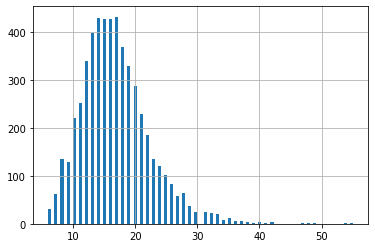

In [17]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_data['Sentence1'] + ' ' + train_data['Sentence2']]
pd.Series(seq_len).hist(bins = 100)

It indicates that we do not need to pad over a length of 65. To ensure that we stay safe with the test data as well, we take a little higher limit.

In [18]:
def dataset_creator(df):
    ## MAX LENGTH HAS BEEN REDUCED FOR FASTER TRAINING
    tokenized_data = tokenizer(list(df['Sentence1']), list(df['Sentence2']),
                               max_length = 70, padding='max_length', truncation=True)
                               
                               
    labels_list = list(df['Label'])
    return tokenized_data, labels_list

In [19]:
train_tokens, train_labels = dataset_creator(train_data)

In [20]:
validation_tokens, validation_labels = dataset_creator(validation_data)

## Creating Dataset

In [21]:
class WMCDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, original_pos1, original_pos2):
        self.encodings = encodings
        self.labels = labels
        self.pos1 = original_pos1
        self.pos2 = original_pos2
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['pos1'] = torch.tensor(self.pos1[idx])
        item['pos2'] = torch.tensor(self.pos2[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [22]:
train_dataset = WMCDataset(train_tokens, train_labels, train_data['Position1'], train_data['Position2_Rel'])
val_dataset = WMCDataset(validation_tokens, validation_labels, validation_data['Position1'], validation_data['Position2_Rel'])

In [23]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [24]:
# count = 0
# for batch in train_loader:
#   # print(batch['pos1'])
#   if count == 0:
#     print(batch['pos2'])
#     count += 1

In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Creating Model

In [31]:
from torch.utils.data import DataLoader
# from transformers import AutoModel, RobertaForMaskedLM, AlbertModel, DistilBertModel, BertForSequenceClassification, AutoModelForSequenceClassification, AdamW
from transformers import BertForSequenceClassification, AdamW

model = BertForSequenceClassification.from_pretrained('bert-base-cased')
# model = DistilBertModel.from_pretrained('bert-base-uncased')
# model = RobertaForMaskedLM.from_pretrained('roberta-base')
# model = AlbertModel.from_pretrained('albert-base-v2')
# model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased')
model.to(device)
model.train()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [32]:
# count = 0
# for name, param in model.named_parameters():
#   count += 1
#   if count < 8:
# 	# if 'classifier' not in name: # classifier layer
#     param.requires_grad = False

In [33]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 108,311,810 trainable parameters


In [34]:
# def multi_acc(y_pred, y_test):
#   acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
#   return acc

In [35]:
optim = AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.CosineEmbeddingLoss()          ## to gain a measure of similarity between the two word embeddings

In [36]:
## Checkpointing: Storing model state
def save_ckp(path, epoch, model, opt, loss):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss,
            }, path)

In [37]:
seed_val = 42

# random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Defining Loss & Accuracy Functions

In [38]:
## Defining accuracy measurements
def accuracy(preds, y):
    acc = torch.sum(preds == y) / y.shape[0]
    return acc

## Function to Calculate Loss
def calculate_loss(last_hidden_state, positions1, positions2, labels):

    ## Picking out the specific word embeddings for out special token form last_hidden_state
    j = 1
    first = last_hidden_state[0, positions1[0], :]
    for i in positions1[1:]:
        first = torch.vstack((first, last_hidden_state[j, i, :]))
        j += 1

    ## Picking out the specific word embeddings for out special token form last_hidden_state
    j = 1
    second = last_hidden_state[0, positions2[0], :]
    for i in positions2[1:]:
        second = torch.vstack((second, last_hidden_state[j, i, :]))
        j += 1

    ## Creating similarity and dissimilarity vector for segregating results
    pred = labels.float()
    y = pred.clone().detach()       ## creating copy of the batch labels
    for i in range(len(y)):
      if y[i] == 0:
          y[i] = -1

    ## Calculating Loss
    
    # print(first.shape)        ## 16*768
    # print(second.shape)       ## 16*768
    
    loss = criterion(first, second, y)
    # print(loss)

    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    res = cos(first, second).float()
    
    for i in range(len(res)):
        if res[i] > 0.1:      
          res[i] = 1
        else:
          res[i] = 0

    ## Generating Accuracy
    acc = accuracy(res, pred)
    return loss, acc

## Defining Model

In [39]:
import time

def train(model, train_loader, val_loader, optim, is_val=True,epochs=5):  
  total_step = len(train_loader)
  val_loss_min = 30

  for epoch in range(epochs):
    start = time.time()
    model.train()
    total_train_loss = 0
    total_train_acc  = 0

    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        seg_ids = batch['token_type_ids'].to(device)
        attention_mask_ids = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        pos1 = batch['pos1'].to(device)
        pos2 = batch['pos2'].to(device)

        output = model( input_ids, 
                                  token_type_ids=seg_ids, 
                                  attention_mask=attention_mask_ids,
                                  # labels=labels,
                                  output_hidden_states=True
                                 )
        
        last_hidden_state = output.hidden_states[-1].to(device)
        # _, prediction, _ = output.values()     ## the ones coming out of the BERT model
        
        loss, acc = calculate_loss(last_hidden_state, pos1, pos2, labels)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        loss.backward()
        optim.step()

        total_train_loss += loss.item()
        total_train_acc  += acc.item()

    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)
    model.eval()
    total_val_acc  = 0
    total_val_loss = 0

    with torch.no_grad():
      if is_val:  
        for batch in val_loader:
          optim.zero_grad()
          input_ids = batch['input_ids'].to(device)
          seg_ids = batch['token_type_ids'].to(device)
          attention_mask_ids = batch['attention_mask'].to(device)
          labels = batch['labels'].to(device)
          pos1 = batch['pos1'].to(device)
          pos2 = batch['pos2'].to(device)

          output = model( input_ids, 
                          token_type_ids=seg_ids, 
                          attention_mask=attention_mask_ids, 
                        #  labels=labels,
                          output_hidden_states=True
                        )
          
          last_hidden_state = output.hidden_states[-1].to(device)
          # _, prediction, _ = output.values()     ## the ones coming out of the BERT model
          
          loss, acc = calculate_loss(last_hidden_state, pos1, pos2, labels)
          # acc = multi_acc(prediction, labels)

          total_val_loss += loss.item()
          total_val_acc  += acc.item()

    val_acc  = total_val_acc/len(val_loader)
    val_loss = total_val_loss/len(val_loader)
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

    ## Saving the model for least val_loss
    if is_val:
      if val_loss < val_loss_min:
          val_loss_min = val_loss
          print('Validation Loss Decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min,val_loss))
          ## Saving checkpoint
          save_ckp('model.txt', epoch+1, model, optim, val_loss_min)

In [40]:
## Training the Model
train(model, train_loader, val_loader, optim, epochs=10)     ## CAN BE RUN FOR MORE EPOCHS

Epoch 1: train_loss: 0.4200 train_acc: 0.5741 | val_loss: 0.3953 val_acc: 0.5808
00:02:29.14
Validation Loss Decreased (0.395299 --> 0.395299).  Saving model ...
Epoch 2: train_loss: 0.2760 train_acc: 0.7445 | val_loss: 0.3652 val_acc: 0.6181
00:02:30.71
Validation Loss Decreased (0.365233 --> 0.365233).  Saving model ...
Epoch 3: train_loss: 0.1841 train_acc: 0.8460 | val_loss: 0.3489 val_acc: 0.6384
00:02:30.66
Validation Loss Decreased (0.348926 --> 0.348926).  Saving model ...
Epoch 4: train_loss: 0.1409 train_acc: 0.8919 | val_loss: 0.3157 val_acc: 0.6826
00:02:30.60
Validation Loss Decreased (0.315695 --> 0.315695).  Saving model ...


RuntimeError: ignored

In [ ]:
train(model, train_loader, val_loader, optim, epochs=1)     ## CAN BE RUN FOR MORE EPOCHS

In [41]:
## Zip the final model and all the required files, such as vocabulary
# Replace USERID with your own, such as 2017CSZ8058
!zip -r 2018ME10032_B_model.zip model.txt

## Upload it to Google drive and ensure that the testing notebook uses the correct link

  adding: model.txt (deflated 21%)


In [42]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
cp /content/2018ME10032_B_model.zip /content/drive/MyDrive/COL772_A3_B